# **20BCE197 NLP Innovative Assignment**

# **Auto Tagging Stack Overflow Questions**

In [1]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns
import os
import warnings
import time
import re
import bs4
from nltk.tokenize import ToktokTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.metrics import make_scorer, confusion_matrix, hamming_loss, accuracy_score, precision_score, recall_score
from sklearn.cluster import KMeans



from keras.models import Sequential
from keras.layers import Dense , Dropout , LSTM , Bidirectional , Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Embedding,Activation, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D 

import logging
from scipy.sparse import hstack

warnings.filterwarnings("ignore")
plt.style.use('bmh')
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
#url_questions = r'/content/drive/MyDrive/Sem_6/NLP/NLP_Innovative/Questions.csv'
url_questions = r'/kaggle/input/stacksample/Questions.csv'
data_questions=pd.read_csv(url_questions,encoding="ISO-8859-1")
data_questions.head(5)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [36]:
# url_answers = r'/content/drive/MyDrive/Sem_6/NLP/NLP_Innovative/Answers.csv'
#url_answers = r'/kaggle/input/stacksample/Answers.csv'
#data_answers=pd.read_csv(url_answers,encoding="ISO-8859-1")
#data_answers.head(5)

In [3]:
#url_tags = r'/content/drive/MyDrive/Sem_6/NLP/NLP_Innovative/Tags.csv'
url_tags = r'/kaggle/input/stacksample/Tags.csv'
data_tags=pd.read_csv(url_tags,encoding="ISO-8859-1",dtype={'Tag': str})
data_tags.head(5)

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [4]:
data_questions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1264216 entries, 0 to 1264215
Data columns (total 7 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   Id            1264216 non-null  int64  
 1   OwnerUserId   1249762 non-null  float64
 2   CreationDate  1264216 non-null  object 
 3   ClosedDate    55959 non-null    object 
 4   Score         1264216 non-null  int64  
 5   Title         1264216 non-null  object 
 6   Body          1264216 non-null  object 
dtypes: float64(1), int64(2), object(4)
memory usage: 67.5+ MB


In [5]:
data_tags.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3750994 entries, 0 to 3750993
Data columns (total 2 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Tag     object
dtypes: int64(1), object(1)
memory usage: 57.2+ MB


# Group tags by id and join them

In [6]:
data_tags['Tag'] = data_tags['Tag'].astype(str)
grouped_tags = data_tags.groupby("Id")['Tag'].apply(lambda tags: ' '.join(tags))
grouped_tags.head(10)

Id
80                               flex actionscript-3 air
90          svn tortoisesvn branch branching-and-merging
120                                  sql asp.net sitemap
180       algorithm language-agnostic colors color-space
260              c# .net scripting compiler-construction
330                           c++ oop class nested-class
470                                    .net web-services
580    sql-server sql-server-2005 deployment release-...
650                          c# visual-studio versioning
810          windows visual-studio registry installation
Name: Tag, dtype: object

In [7]:
grouped_tags.shape

(1264216,)

# Reset index for making simpler dataframe

In [8]:
grouped_tags.reset_index()
grouped_tags_final = pd.DataFrame({'Id':grouped_tags.index, 'Tags':grouped_tags.values})
grouped_tags_final.head(5)

,Id,Tags
0,80,flex actionscript-3 air
1,90,svn tortoisesvn branch branching-and-merging
2,120,sql asp.net sitemap
3,180,algorithm language-agnostic colors color-space
4,260,c# .net scripting compiler-construction


# Drop unnecessary columns

In [9]:
data_questions.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate'], inplace=True)

# Merge questions and tags into one dataframe

In [10]:
data = data_questions.merge(grouped_tags_final, on='Id')
data.head(10)

,Id,Score,Title,Body,Tags
0,80,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,90,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,120,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,180,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,260,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction
5,330,29,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,c++ oop class nested-class
6,470,13,Homegrown consumption of web services,<p>I've been writing a few web services for a ...,.net web-services
7,580,21,Deploying SQL Server Databases from Test to Live,<p>I wonder how you guys manage deployment of ...,sql-server sql-server-2005 deployment release-...
8,650,79,Automatically update version number,<p>I would like the version property of my app...,c# visual-studio versioning
9,810,9,Visual Studio Setup Project - Per User Registr...,<p>I'm trying to maintain a Setup Project in <...,windows visual-studio registry installation


# Find the Minimum and Maximun Score

In [11]:
print(f"Minimum Score: {data['Score'].min()}")
print(f"Maximum Score: {data['Score'].max()}")

Minimum Score: -73
Maximum Score: 5190


# Deleting queries with score less than 5

In [12]:
new_data_questions = data[data['Score'] > 5]

In [13]:
print(data.shape)
print(new_data_questions.shape)

(1264216, 5)
(72950, 5)


In [14]:
new_data_questions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72950 entries, 0 to 1264205
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      72950 non-null  int64 
 1   Score   72950 non-null  int64 
 2   Title   72950 non-null  object
 3   Body    72950 non-null  object
 4   Tags    72950 non-null  object
dtypes: int64(2), object(3)
memory usage: 3.3+ MB


### Removew the ID and Score Columns

In [15]:
new_data_questions.drop(columns=['Id', 'Score'], inplace=True)
new_data_questions.head()

,Title,Body,Tags
0,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex actionscript-3 air
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn tortoisesvn branch branching-and-merging
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,sql asp.net sitemap
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,algorithm language-agnostic colors color-space
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c# .net scripting compiler-construction


## Preprocessing on Tags

In [16]:
#convert tag string into the list
new_data_questions['Tags'] = new_data_questions['Tags'].apply(lambda x: x.split())
print(new_data_questions.head(10))

                                               Title  \
0  SQLStatement.execute() - multiple queries in o...   
1  Good branching and merging tutorials for Torto...   
2                                  ASP.NET Site Maps   
3                 Function for creating color wheels   
4  Adding scripting functionality to .NET applica...   
5          Should I use nested classes in this case?   
6              Homegrown consumption of web services   
7   Deploying SQL Server Databases from Test to Live   
8                Automatically update version number   
9  Visual Studio Setup Project - Per User Registr...   

                                                Body  \
0  <p>I've written a database generation script i...   
1  <p>Are there any really good tutorials explain...   
2  <p>Has anyone got experience creating <strong>...   
3  <p>This is something I've pseudo-solved many t...   
4  <p>I have a little game written in C#. It uses...   
5  <p>I am working on a collection of classes u

In [17]:
flat_list = [item for sublist in new_data_questions['Tags'].values for item in sublist]
keywords = nltk.FreqDist(flat_list)
keywords = nltk.FreqDist(keywords)
sum(keywords.values())

224129

In [18]:
unique_tags = list(set([item for sublist in new_data_questions['Tags'].values for item in sublist]))
len(unique_tags)
#print(unique_tags)

14883

In [19]:
flat_list = [item for sublist in new_data_questions['Tags'].values for item in sublist]
keywords = nltk.FreqDist(flat_list)
frequencies_words = keywords.most_common(100)
tags_features = [word[0] for word in frequencies_words]
tags_features

['c#',
 'java',
 'javascript',
 'android',
 'python',
 'c++',
 'php',
 'jquery',
 '.net',
 'ios',
 'html',
 'css',
 'c',
 'iphone',
 'objective-c',
 'ruby-on-rails',
 'sql',
 'asp.net',
 'mysql',
 'ruby',
 'r',
 'git',
 'asp.net-mvc',
 'linux',
 'sql-server',
 'node.js',
 'angularjs',
 'django',
 'performance',
 'algorithm',
 'string',
 'xcode',
 'arrays',
 'wpf',
 'eclipse',
 'haskell',
 'windows',
 'scala',
 'multithreading',
 'json',
 'c++11',
 'regex',
 'visual-studio',
 'html5',
 'osx',
 'swift',
 'database',
 'unit-testing',
 'spring',
 'xml',
 'bash',
 'ajax',
 'delphi',
 'cocoa-touch',
 'ruby-on-rails-3',
 'visual-studio-2010',
 'linq',
 'debugging',
 'generics',
 'perl',
 'entity-framework',
 'mongodb',
 'winforms',
 'cocoa',
 'security',
 'postgresql',
 'css3',
 'templates',
 'twitter-bootstrap',
 'shell',
 'list',
 'google-chrome',
 'vim',
 'oop',
 'image',
 'hibernate',
 'gcc',
 'asp.net-mvc-3',
 'facebook',
 'oracle',
 'rest',
 'maven',
 'http',
 'exception',
 'tsql',
 'ma

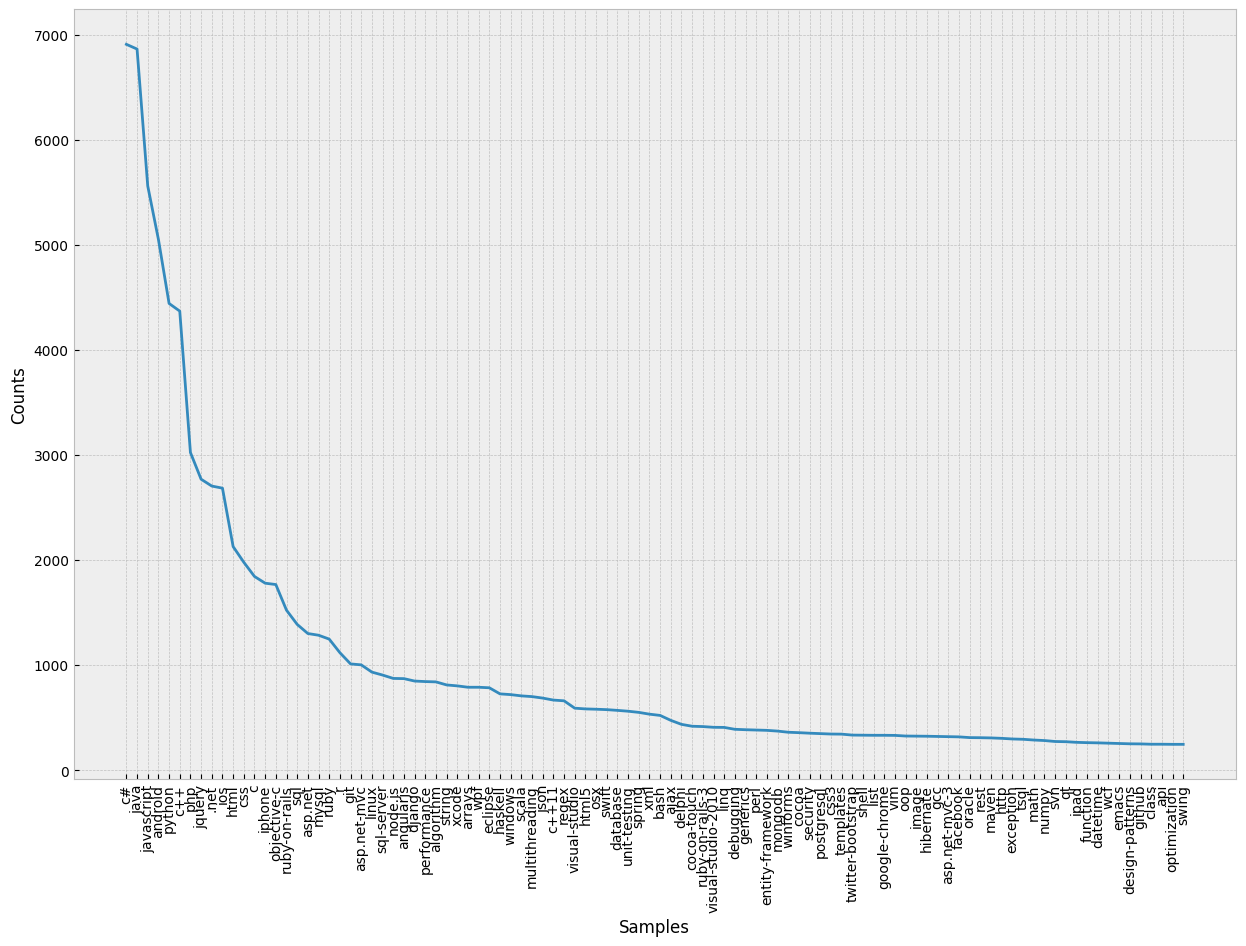

In [20]:
fig, ax = plt.subplots(figsize=(15, 10))
keywords.plot(100, cumulative=False)

In [21]:
def most_common(tags):
    tags_filtered = []
    for i in range(len(tags)):
        if tags[i] in tags_features:
            tags_filtered.append(tags[i])
    return tags_filtered

In [22]:
new_data_questions['Tags'] = new_data_questions['Tags'].apply(lambda x: most_common(x))
new_data_questions['Tags'] = new_data_questions['Tags'].apply(lambda x: x if len(x) > 0 else None)
new_data_questions.dropna(subset=['Tags'], inplace=True)
new_data_questions

,Title,Body,Tags
1,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,[svn]
2,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...,"[sql, asp.net]"
3,Function for creating color wheels,<p>This is something I've pseudo-solved many t...,[algorithm]
4,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,"[c#, .net]"
5,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,"[c++, oop, class]"
...,...,...,...
1262834,STL list very bad performance,"<p>It's supposed that ""push_back"" and ""pop_fro...","[c++, list]"
1262915,How to use a dict to subset a DataFrame?,"<p>Say, I have given a DataFrame with most of ...",[python]
1263065,Is there a way to use itertools in python to c...,<p>Let's say I have the following code:</p>\n\...,[python]
1263454,Why does my result data returned as void* gets...,<p>I am working in a project with a huge legac...,[c++]


# Preprocessing on Body and Title

In [23]:
# Converting html to text in the body
new_data_questions['Body'] = new_data_questions['Body'].apply(lambda x: BeautifulSoup(x).get_text()) 

In [58]:
#nltk.download('all')
#!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

In [27]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [28]:
import re

In [29]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\'scuse", " excuse ", text)
    text = re.sub(r"\'\n", " ", text)
    text = re.sub(r"\'\xa0", " ", text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

token = ToktokTokenizer()
punct = '!"#$%&\'()*+,./:;<=>?@[\\]^_`{|}~'
lemma = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def strip_list_noempty(mylist):
    newlist = (item.strip() if hasattr(item, 'strip') else item for item in mylist)
    return [item for item in newlist if item != '']

def clean_punct(text): 
    words = token.tokenize(text)
    punctuation_filtered = []
    regex = re.compile('[%s]' % re.escape(punct))
    remove_punctuation = str.maketrans(' ', ' ', punct)
    for w in words:
        if w in tags_features:
            punctuation_filtered.append(w)
        else:
            punctuation_filtered.append(regex.sub('', w))
    filtered_list = strip_list_noempty(punctuation_filtered)
    return ' '.join(map(str, filtered_list))

def lemmatizeWords(text):
    words = token.tokenize(text)
    listLemma = []
    for w in words:
        x = lemma.lemmatize(w, "v")
        listLemma.append(x)
    return ' '.join(map(str, listLemma))



def stopWordsRemove(text):
    stop_words = set(stopwords.words("english"))
    words = token.tokenize(text)
    filtered = [w for w in words if not w in stop_words]
    return ' '.join(map(str, filtered))

In [30]:
# Remove stopwords, punctuation and lemmatize for text in body
new_data_questions['Body'] = new_data_questions['Body'].apply(lambda x: clean_text(x)) 
new_data_questions['Body'] = new_data_questions['Body'].apply(lambda x: clean_punct(x)) 
new_data_questions['Body'] = new_data_questions['Body'].apply(lambda x: lemmatizeWords(x))
new_data_questions['Body'] = new_data_questions['Body'].apply(lambda x: stopWordsRemove(x))

#Remove stopwords, punctuation and lemmatize for title.
new_data_questions['Title'] = new_data_questions['Title'].apply(lambda x: str(x))
new_data_questions['Title'] = new_data_questions['Title'].apply(lambda x: clean_text(x)) 
new_data_questions['Title'] = new_data_questions['Title'].apply(lambda x: clean_punct(x)) 
new_data_questions['Title'] = new_data_questions['Title'].apply(lambda x: lemmatizeWords(x)) 
new_data_questions['Title'] = new_data_questions['Title'].apply(lambda x: stopWordsRemove(x)) 

In [31]:
#data is finally cleaned and preprocessed
new_data_questions

,Title,Body,Tags
1,good branch merge tutorials tortoisesvn,really good tutorials explain branch merge apa...,[svn]
2,asp.net site map,anyone get experience create sql-based asp.net...,"[sql, asp.net]"
3,function create color wheel,something pseudo-solved many time never quite ...,[algorithm]
4,add script functionality .net applications,little game write c use database back-end trad...,"[c#, .net]"
5,use nest class case,work collection class use video playback recor...,"[c++, oop, class]"
...,...,...,...
1262834,stl list bad performance,suppose pushback popfront methods stl list imp...,"[c++, list]"
1262915,use dict subset dataframe,say give dataframe columns categorical data da...,[python]
1263065,way use itertools python clean nest iterations,let say follow code 123 b 246 c 357 j b k c pr...,[python]
1263454,result data return void get break,work project huge legacy code base try re-desi...,[c++]


In [32]:
new_data_questions['Combined_text'] = new_data_questions['Title'] + ' ' + new_data_questions['Body']

# Data Preparation

In [33]:
X1 = new_data_questions['Body']
X2 = new_data_questions['Title']
y = new_data_questions['Tags']
XC = new_data_questions['Combined_text']

In [34]:
multilabel_binarizer = MultiLabelBinarizer()
y_bin = multilabel_binarizer.fit_transform(y)

In [35]:
y_bin

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [36]:
vectorizer_X1 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

vectorizer_X2 = TfidfVectorizer(analyzer = 'word',
                                       min_df=0.0,
                                       max_df = 1.0,
                                       strip_accents = None,
                                       encoding = 'utf-8', 
                                       preprocessor=None,
                                       token_pattern=r"(?u)\S\S+",
                                       max_features=1000)

In [37]:
X1_tfidf = vectorizer_X1.fit_transform(X1)
X2_tfidf = vectorizer_X2.fit_transform(X2)
XC_tfidf = vectorizer_X1.fit_transform(XC)
X_tfidf = hstack([X1_tfidf,X2_tfidf])

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_bin, test_size = 0.2, random_state = 0)

In [39]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50533, 2000)
(50533, 100)
(12634, 2000)
(12634, 100)


# Classical classifiers

In [40]:
from sklearn.metrics import accuracy_score
from sklearn.svm import LinearSVC
from sklearn.metrics import hamming_loss
from sklearn.metrics import f1_score
from skmultilearn.problem_transform import LabelPowerset
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
#from sklearn.metrics import jaccard_similarity_score
from sklearn import model_selection
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

In [41]:
def avg_jacard(y_true,y_pred):
    '''
    see https://en.wikipedia.org/wiki/Multi-label_classification#Statistics_and_evaluation_metrics
    '''
    jacard = np.minimum(y_true,y_pred).sum(axis=1) / np.maximum(y_true,y_pred).sum(axis=1)
    
    return jacard.mean()*100

def print_score(y_pred, clf):
    print("Clf: ", clf.__class__.__name__)
    #print("Accuracy score: {}".format(accuracy_score(y_test, y_pred)))
    print("Recall score: {}".format(recall_score(y_true=y_test, y_pred=y_pred, average='weighted')))
    print("Precision score: {}".format(precision_score(y_true=y_test, y_pred=y_pred, average='weighted')))
    print("F1 score: {}".format(f1_score(y_pred, y_test, average='weighted')))
    #print("Jacard score: {}".format(avg_jacard(y_test, y_pred)))
    print("Hamming loss: {}".format(hamming_loss(y_pred, y_test)*100))
    print("---")    

In [42]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

sgd = SGDClassifier()
lr = LogisticRegression()
mn = MultinomialNB()
svc = LinearSVC()
perceptron = Perceptron()
pac = PassiveAggressiveClassifier()

for classifier in [ sgd, lr, mn, svc, perceptron, pac]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print_score(y_pred, classifier)

Clf:  SGDClassifier
Recall score: 0.4499169058770207
Precision score: 0.8353493866771038
F1 score: 0.6547567123219346
Hamming loss: 0.9572581921798322
---
Clf:  LogisticRegression
Recall score: 0.47262929949136323
Precision score: 0.8044102409333095
F1 score: 0.6402160498404779
Hamming loss: 0.9712680069653316
---
Clf:  MultinomialNB
Recall score: 0.4353628443370096
Precision score: 0.7179386699846309
F1 score: 0.5740617208928167
Hamming loss: 1.1750039575747981
---
Clf:  LinearSVC
Recall score: 0.5245001762602609
Precision score: 0.7733977606602136
F1 score: 0.6562077822735736
Hamming loss: 0.9552794047807505
---
Clf:  Perceptron
Recall score: 0.5550183814272045
Precision score: 0.5456538568363644
F1 score: 0.5452008118817772
Hamming loss: 1.4487098306157986
---
Clf:  PassiveAggressiveClassifier
Recall score: 0.5544140605328096
Precision score: 0.6081490636008812
F1 score: 0.5807364932602033
Hamming loss: 1.2673737533639384
---


In [75]:
#Randomforest
#rfc = RandomForestClassifier()
#rfc.fit(X_train, y_train)
#y_pred = rfc.predict(X_test)
#print_score(y_pred, rfc)

# Deep learning Model -1

In [43]:
import keras
def dense_model():
    inputs = keras.Input(shape=(2000,))
    x = keras.layers.Dense(1800, activation='relu')(inputs)
    x = keras.layers.Dense(1200, activation = 'relu')(x)
    x = keras.layers.Dense(1000, activation = 'relu')(x)
    x = keras.layers.Dense(600, activation = 'relu')(x)
    x = keras.layers.Dense(300, activation = 'relu')(x)
    x = keras.layers.Dense(100, activation = 'relu')(x)
    x = keras.layers.Dense(75, activation = 'relu')(x)
    output = keras.layers.Dense(100, activation = 'sigmoid')(x)
    model = keras.Model(inputs=inputs, outputs=output)
    return model

In [44]:
model_1 = dense_model()
model_1.compile(optimizer="adam",loss="binary_crossentropy" , metrics = ['accuracy'])
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2000)]            0         
                                                                 
 dense (Dense)               (None, 1800)              3601800   
                                                                 
 dense_1 (Dense)             (None, 1200)              2161200   
                                                                 
 dense_2 (Dense)             (None, 1000)              1201000   
                                                                 
 dense_3 (Dense)             (None, 600)               600600    
                                                                 
 dense_4 (Dense)             (None, 300)               180300    
                                                                 
 dense_5 (Dense)             (None, 100)               30100 

In [45]:
model_1.fit(X_train , y_train , epochs = 50)

Epoch 1/50
1580/1580 [==============================] - 52s 29ms/step - loss: 0.0646 - accuracy: 0.2716
Epoch 2/50
1580/1580 [==============================] - 13s 8ms/step - loss: 0.0392 - accuracy: 0.5135
Epoch 3/50
1580/1580 [==============================] - 12s 7ms/step - loss: 0.0303 - accuracy: 0.5961
Epoch 4/50
1580/1580 [==============================] - 11s 7ms/step - loss: 0.0237 - accuracy: 0.6516
Epoch 5/50
1580/1580 [==============================] - 10s 6ms/step - loss: 0.0191 - accuracy: 0.6867
Epoch 6/50
1580/1580 [==============================] - 10s 6ms/step - loss: 0.0156 - accuracy: 0.7068
Epoch 7/50
1580/1580 [==============================] - 10s 6ms/step - loss: 0.0131 - accuracy: 0.7219
Epoch 8/50
1580/1580 [==============================] - 10s 6ms/step - loss: 0.0111 - accuracy: 0.7313
Epoch 9/50
1580/1580 [==============================] - 10s 6ms/step - loss: 0.0098 - accuracy: 0.7318
Epoch 10/50
1580/1580 [==============================] - 10s 6ms/step - 

In [46]:
model_1.evaluate(X_test , y_test)

395/395 [==============================] - 2s 4ms/step - loss: 0.0901 - accuracy: 0.5296


[0.0900910422205925, 0.5296026468276978]